# Code Appendix

In [ ]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import pydot
import graphviz
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
import time
import scipy
import powerlaw
from IPython.display import Image
import time
from libs.mrqap8 import MRQAP
%matplotlib inline

### Read in and Clean Commuting Matrix and Supplementary Data {-}

In [ ]:
#read in OD Matrix
df = pd.read_csv('Data/travel_matrix_spo2017.csv')

#read in Commuting Survey appendix file with further information on zones
labels= pd.read_excel('Data/zone_labels.xlsx', skiprows=3, header = 1)

#clean and merge dataframes
labels = labels[2:]
labels['Zona'] = labels[labels['Zona'] != 'nan']
labels['Zona'] = labels[labels['Zona'] != 'N°']
labels['Zona'] = labels[labels['Zona'] != 'Zona']
labels['Zona'] = labels['Zona'].astype(float)
df = df.merge(labels, left_on='ZONA_O', right_on='Zona')

df.to_csv('for_gephi.csv')

#remove missing values
df = df[~df['ZONA_O'].isnull()]
df = df[~df['ZONA_D'].isnull()]
df = df[df['ZONA_O'] != 'nan']
df = df[df['ZONA_D'] != 'nan']
df = df[~df['mean_time'].isnull()]

df.to_csv('traffic_flow.csv')
#creat graph


In [ ]:
#get number of unique municipalities in dataset
len(df['Município'].unique())

39

In [ ]:
df.rename(columns={'Unnamed: 3': 'Municipality'}, inplace=True)

### Match Origin and Destination Regions with their Municipalities {-}

In [ ]:
#match origin regoins with their municipalities
munic = df[['ZONA_O', 'Municipality']]

munic.drop_duplicates(subset=['ZONA_O', 'Municipality'], inplace=True)

#add matched municipality to travel origin 
travel = df[['ZONA_O', 'ZONA_D', 'count', 'lon_orig', 'lat_orig', 'lon_dest', 'lat_dest', 'pop_orig', 'pop_dest', 'mean_time']].merge(munic, left_on=['ZONA_O'], right_on=['ZONA_O'])
travel.rename(columns={'Municipality': 'orig_munic'}, inplace=True)

#add matched municipality to travel destination
travel = travel[['ZONA_O', 'ZONA_D', 'count', 'mean_time', 'lon_orig', 'lat_orig', 'lon_dest', 'lat_dest', 'pop_orig', 'pop_dest', 'orig_munic']].merge(munic, left_on=['ZONA_D'], right_on=['ZONA_O'])
travel.rename(columns={'Municipality': 'dest_munic'}, inplace=True)

travel.rename(columns={'ZONA_O_x': 'ZONA_O'}, inplace=True)

travel.drop('ZONA_O_y', axis=1,  inplace=True)

### Match Origin and Destination Regions with their Areas {-}

In [ ]:
#add area to origin zone
munic = df[['ZONA_O', 'Área']]

munic.drop_duplicates(subset=['ZONA_O', 'Área'], inplace=True)

travel = travel[['ZONA_O', 'ZONA_D', 'count', 'mean_time', 'lon_orig', 'lat_orig', 'lon_dest', 'lat_dest', 'pop_orig', 'pop_dest', 'orig_munic', 'dest_munic']].merge(munic, left_on=['ZONA_O'], right_on=['ZONA_O'])
travel.rename(columns={'Área': 'orig_area'}, inplace=True)

travel = travel[['ZONA_O', 'ZONA_D', 'count', 'mean_time', 'lon_orig', 'lat_orig', 'lon_dest', 'lat_dest', 'pop_orig', 'pop_dest', 'orig_munic', 'dest_munic', 'orig_area']].merge(munic, left_on=['ZONA_D'], right_on=['ZONA_O'])
travel.rename(columns={'Área': 'dest_area'}, inplace=True)

travel.drop('ZONA_O_y', axis=1, inplace=True)

travel.rename(columns={'ZONA_O_x' :'ZONA_O'}, inplace=True)

### Create Independent Variables for QAP {-}
    1. Same Municipality
    2. Population density ratio

In [ ]:
travel['same_munic'] = [2 if x==y else 1 for x,y in zip(travel['orig_munic'], travel['dest_munic'])]


travel['orig_pop_dens'] = [(x /y) for x,y in zip(travel['pop_orig'], travel['orig_area'])]
travel['dest_pop_dens'] = [(x /y) for x,y in zip(travel['pop_dest'], travel['dest_area'])]
travel['pop_dens_ratio'] =  [(x /y) for x,y in zip(travel['orig_pop_dens'], travel['dest_pop_dens'])]

### Convert Dataframe to Network, Add Node Attributes (Lat, Lon, Population) to Network {-}

In [ ]:
G = nx.from_pandas_edgelist(travel, 'ZONA_O', 'ZONA_D', edge_attr = ['count', 'mean_time', 'same_munic', 'pop_dens_ratio'], create_using=nx.MultiDiGraph)

#add node attributes
dic = {}
for index, row in travel.iterrows():
    dic[row['ZONA_O']] = {'pop': row['pop_orig'], 'area': row['orig_area'], 'lon': row['lon_orig'], 'lat': row['lat_orig'], 'municipality': row['orig_munic']}

nx.set_node_attributes(G, dic)
nx.write_gexf(G, 'OD_matrix.gexf')

In [ ]:
G = nx.readwrite.gexf.read_gexf('OD_matrix.gexf')

### View Network Summary Statistics {-}

In [ ]:
nx.density(G)

0.11421087098886706

In [ ]:
nx.average_shortest_path_length(G)

2.0479795061443045

In [ ]:
nx.average_shortest_path_length(G, weight='mean_time')

66.86321938519791

In [ ]:
G.number_of_nodes()

510

In [ ]:
G.number_of_edges()

29648

In [ ]:
nx.is_weakly_connected(G)

True

In [ ]:
nx.transitivity(G)

0.34553943688554123

In [ ]:
nx.diameter(G)

5

# Section 1: Degree Distribution Analysis {-}

### Get Indegree Distribution Values {-}

In [ ]:
indegree_dist = G.in_degree()
indegree_dist = list(indegree_dist)

In [ ]:
for_pandas = np.array(in_degrees)

In [ ]:
#get summary statistics for indegree distribution
print(df.describe().to_latex())

\begin{tabular}{lr}
\toprule
{} &  Sao Paulo In-Degrees \\
\midrule
count &            511.000000 \\
mean  &             67.150685 \\
std   &             43.771452 \\
min   &              1.000000 \\
25\%   &             38.000000 \\
50\%   &             56.000000 \\
75\%   &             87.500000 \\
max   &            280.000000 \\
\bottomrule
\end{tabular}



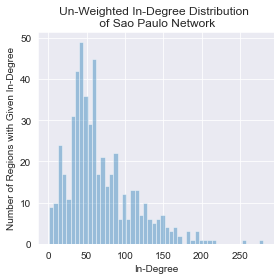

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.distplot(in_degrees, norm_hist=False, kde=False, bins = 50)
plt.title("Un-Weighted In-Degree Distribution \n of Sao Paulo Network")
plt.xlabel("In-Degree")
plt.ylabel("Number of Regions with Given In-Degree")
plt.tight_layout()
plt.savefig("Un-Weigted in Degree.png", dpi=300)

### Get Weighted-Indegree Distribution Values {-}

In [ ]:
w_indegrees = list(G.in_degree(weight='count'))
w_indegrees = [x[1] for x in w_indegrees]

In [ ]:
#get summary statistics for weighted in-degree
for_pandas = np.array(w_indegrees)
df = pd.DataFrame(for_pandas)
df.rename(columns={0: 'Sao Paulo Weighted In-Degrees'}, inplace=True)

In [ ]:
print(df.describe().to_latex())

\begin{tabular}{lr}
\toprule
{} &  Sao Paulo Weighted In-Degrees \\
\midrule
count &                     511.000000 \\
mean  &                   97189.837441 \\
std   &                   75181.881687 \\
min   &                     124.908355 \\
25\%   &                   45445.205261 \\
50\%   &                   81865.250093 \\
75\%   &                  125083.415741 \\
max   &                  550320.773386 \\
\bottomrule
\end{tabular}



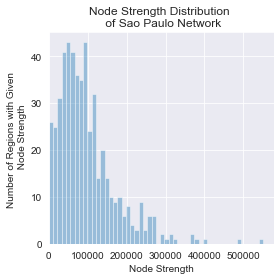

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 4))
sns.distplot(w_indegrees, norm_hist=False, kde=False, ax=ax, bins = 50)
plt.title("Node Strength Distribution \n of Sao Paulo Network")
plt.xlabel("Node Strength")
plt.ylabel("Number of Regions with Given \n Node Strength")
plt.tight_layout()
ax.set_xlim(left=0)
plt.savefig("Weigted in Degree.png", dpi=300)

### Un-Weighted In-Degree {-}

### Fit and Plot Power-Law on Full In-Degree Distribution {-}

In [ ]:
fit1 = powerlaw.Fit(in_degrees, xmin=1.0) 

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))


ax = fit1.plot_ccdf(color='b', linewidth=2, label='In-Degree Distribution')
fit1.power_law.plot_ccdf(color='r', linestyle='--', ax=ax, label='Powerlaw Fit')
fit1.lognormal.plot_ccdf(color='g', linestyle='--', ax=ax, label='Lognormal Fit')
ax.set_title('Power-Law and Lognormal Fit on \n In-Degree Distribution (log CCDF)')
plt.ylabel('P(X≥x)')
plt.xlabel('In-Degree')
plt.legend()
plt.tight_layout()

plt.savefig("GOOD Un-Weigted powerlaw .png", dpi=300)

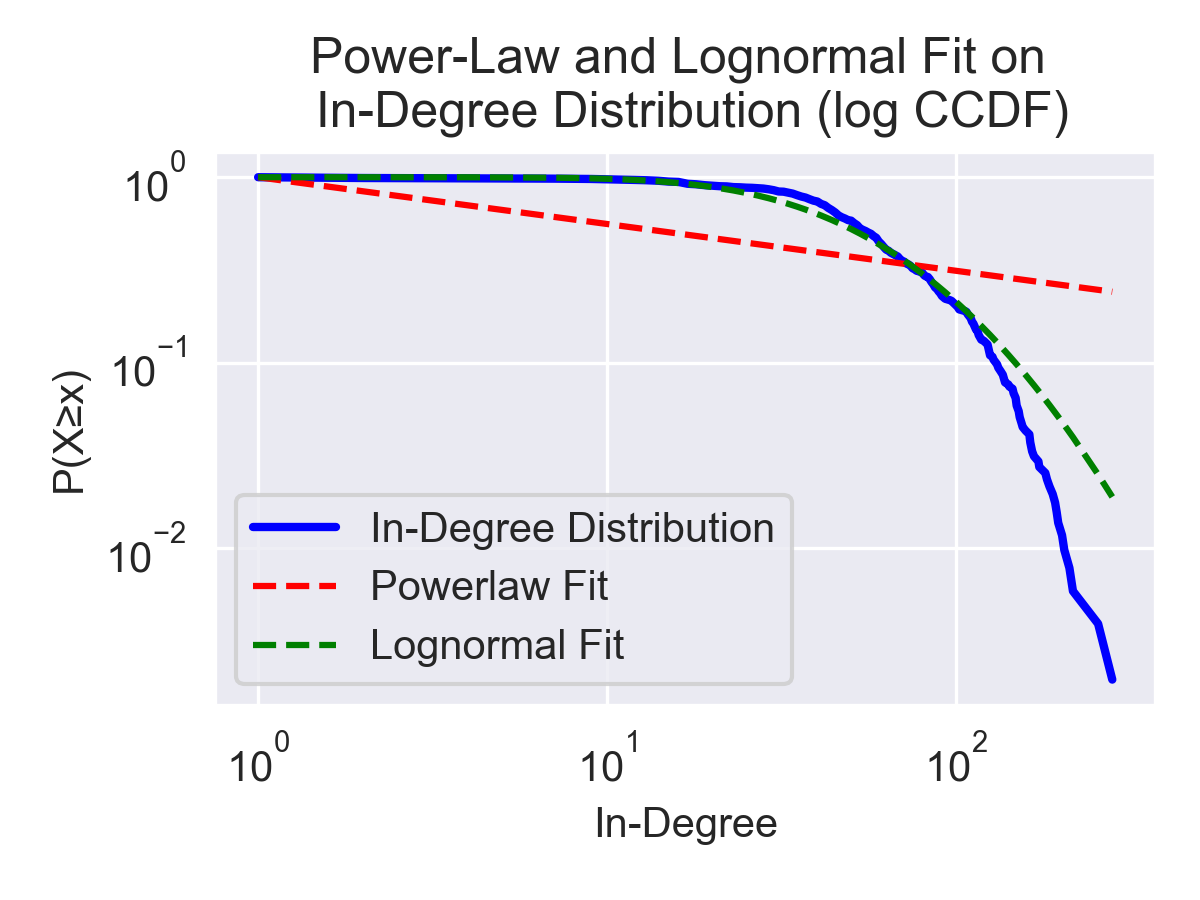

In [ ]:
Image(filename='GOOD Un-Weigted powerlaw .png', width=300)

In [ ]:
#get P-value of Powerlaw vs. lognormal
R, p = fit.distribution_compare('power_law', 'lognormal')

### Fit and Plot Power-Law on Tail of In-Degree Distribution {-}

In [ ]:
fit = powerlaw.Fit(in_degrees, xmin=10**2) 

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = fit.plot_ccdf(color='b', linewidth=2, label='In-Degree Distribution')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=ax, label='Powerlaw Fit')
fit.lognormal.plot_ccdf(color='g', linestyle='--', ax=ax, label='Lognormal Fit')
ax.set_title('Power-Law and Lognormal Fit on \n Tail of In-Degree Distribution (log CCDF)')
ax.set_xticks([10**2, 1.75*10**2, 2.75*10**2], minor=True)
plt.ylabel('P(X≥x)')
plt.xlabel('In-Degree')
plt.legend()
plt.tight_layout()
plt.savefig("GOOD TAIL Un-Weigted powerlaw tail.png", dpi=300)

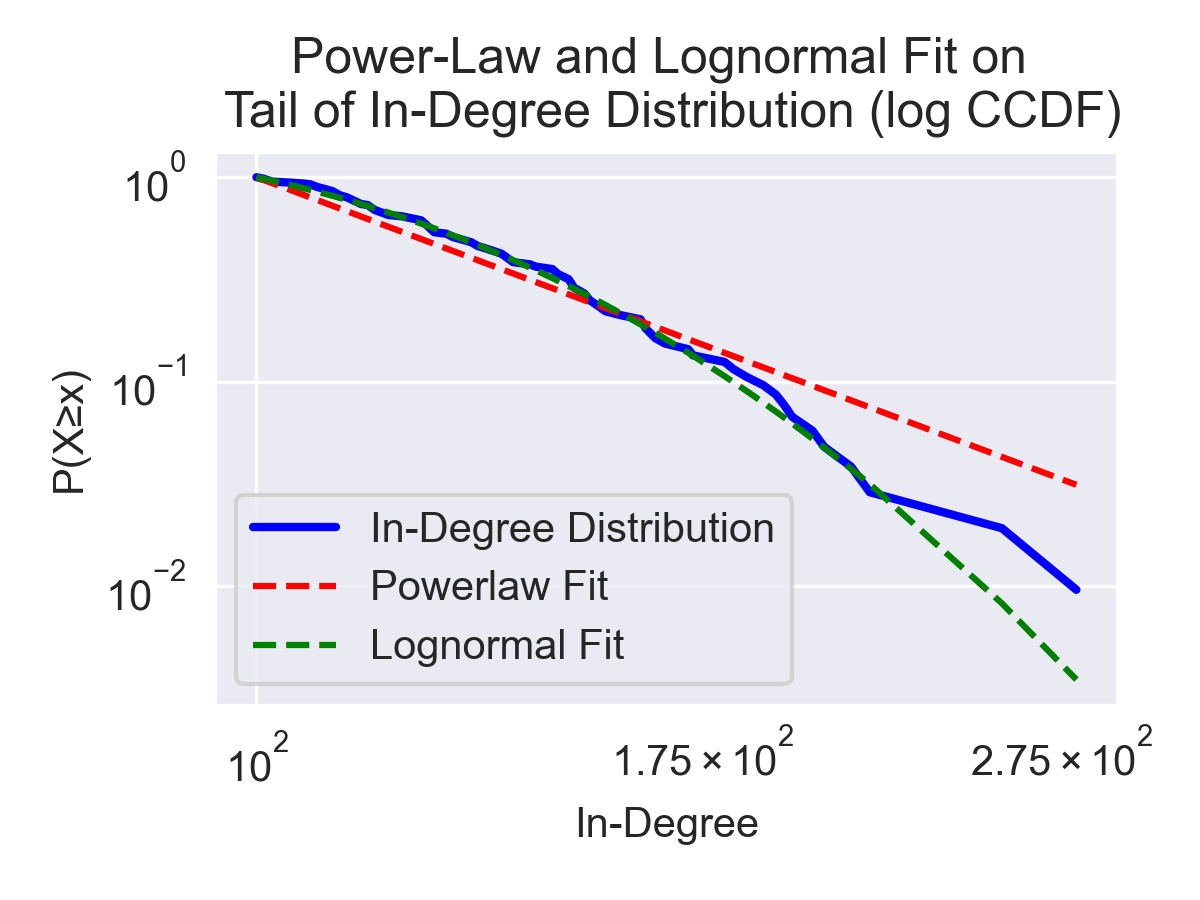

In [ ]:
Image(filename='GOOD TAIL Un-Weigted powerlaw tail.png', width=300)

In [ ]:
#get P-value of Powerlaw vs. lognormal
R, p = fit.distribution_compare('power_law', 'lognormal')

### Weighted In-Degree {-}

### Fit and Plot Weighted Power Law Plot (Full Distribution) {-}

In [ ]:
fit = powerlaw.Fit(w_indegrees, xmin=1.0) 

In [ ]:
w_indegrees.sort()

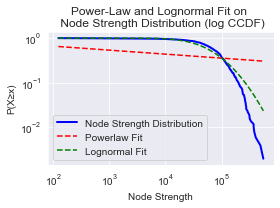

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 3))
ax = fit.plot_ccdf(color='b', linewidth=2, label='Node Strength Distribution')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=ax, label='Powerlaw Fit')
fit.lognormal.plot_ccdf(color='g', linestyle='--', ax=ax, label='Lognormal Fit')
ax.set_title('Power-Law and Lognormal Fit on \n Node Strength Distribution (log CCDF)')
plt.ylabel('P(X≥x)')
plt.xlabel('Node Strength')
plt.legend()
plt.tight_layout()

plt.savefig("Good Weigted powerlaw logscale.png", dpi=300)

In [ ]:
#get P-value of Powerlaw vs. lognormal
R, p = fit.distribution_compare('power_law', 'lognormal')

### Fit and Plot Weighted Power Law Distribution (Tail Distribution) {-}

In [ ]:
import powerlaw 
fit = powerlaw.Fit(w_indegrees, xmin=10**5) 

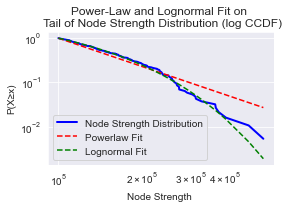

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = fit.plot_ccdf(color='b', linewidth=2, label='Node Strength Distribution')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=ax, label='Powerlaw Fit')
fit.exponential.plot_ccdf(color='g', linestyle='--', ax=ax, label='Lognormal Fit')
ax.set_title('Power-Law and Lognormal Fit on \n Tail of Node Strength Distribution (log CCDF)')
#ax.set_xticks([10**2, 1.75*10**2, 2.75*10**2], minor=True)
plt.ylabel('P(X≥x)')
plt.xlabel('Node Strength ')
plt.legend()
#plt.xticks(ticks=[10**2, 2.75*10**2])
plt.tight_layout()


plt.savefig("Good TAIL Weigted powerlaw logscale.png", dpi=300)

In [ ]:
#get P-value of Powerlaw vs. lognormal
R, p = fit.distribution_compare('power_law', 'lognormal')

### Get Correlation of Un-Weighted and Weighted In-Degree (and plot) {-}

In [ ]:
indegree_df = pd.DataFrame()
indegree_df['dist'] = [x for x in indegree_dist]

indegree_df['node'] = [x[0] for x in indegree_df['dist']]
indegree_df['unweighted_indegree'] = [x[1] for x in indegree_df['dist']]
indegree_df

w_indegree_df = pd.DataFrame()
w_indegree_df['dist'] = [x for x in w_indegrees]
w_indegree_df['node'] = [x[0] for x in w_indegree_df['dist']]
w_indegree_df['weighted_indegree'] = [x[1] for x in w_indegree_df['dist']]

merged = indegree_df.merge(w_indegree_df, left_on='node', right_on='node')

merged = merged[['node', 'unweighted_indegree', 'weighted_indegree']]

merged['unweighted_indegree'].corr(merged['weighted_indegree'])

0.41518629719695505

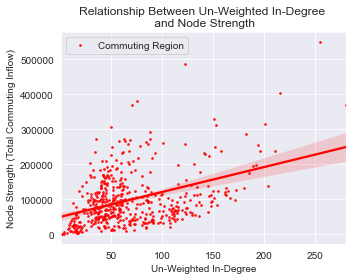

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(5, 4))
sns.regplot(x='unweighted_indegree', y='weighted_indegree', data=merged, label='Commuting Region', color='red', ax=ax, scatter_kws={'s':3})
ax.set_title('Relationship Between Un-Weighted In-Degree \n and Node Strength')
ax.set_xlabel("Un-Weighted In-Degree")
ax.set_ylabel("Node Strength (Total Commuting Inflow)")
plt.tight_layout()
plt.legend()
plt.savefig('images/degree_corr.png', dpi=300)

# Section 2: MRQAP Analysis {-}

### Prepare Adjacency Matricies for QAP {-}

In [ ]:
Y = nx.linalg.graphmatrix.adjacency_matrix(G, weight='count')
X1 = nx.linalg.graphmatrix.adjacency_matrix(G, weight='mean_time')
X2 = nx.linalg.graphmatrix.adjacency_matrix(G, weight='same_munic')
X3 = nx.linalg.graphmatrix.adjacency_matrix(G, weight='pop_dens_ratio')

Y = scipy.sparse.csr_matrix.toarray(Y)
#replace disconnected nodes with Nan
Y[Y == 0] = np.nan



X1 = scipy.sparse.csr_matrix.toarray(X1)
X2 = scipy.sparse.csr_matrix.toarray(X2)
X3 = scipy.sparse.csr_matrix.toarray(X3)


#replace disconnected nodes with Nan
X1[X1 == 0] = np.nan


X2[X2 == 0] = np.nan
X2 = np.where(X2==1, 0, X2)
X2 = np.where(X2==2, 1, X2)

X3[X3 == 0] = np.nan

In [ ]:
X = {'mean_time': X1, 'same_munic': X2, 'pop_dens_ratio': X3}
Y = {'count': Y}

### Run QAP {-}

In [ ]:
start_time = time.time()
mrqap = MRQAP(Y=Y, X=X, npermutations=1000, diagonal=False, directed=True)
mrqap.mrqap()
mrqap.summary()

FULL MEMORY: 
- Virtual Memory: svmem(total=8589934592, available=569085952, percent=93.4, used=901500928, free=15368192, active=555372544, inactive=551665664, wired=346128384)
- Swap Memory: sswap(total=3221225472, used=2376597504, free=844627968, percent=73.8, sin=8087064576, sout=527925248)
FULL MEMORY: 
- Virtual Memory: svmem(total=8589934592, available=563593216, percent=93.4, used=907177984, free=16797696, active=542236672, inactive=545259520, wired=364941312)
- Swap Memory: sswap(total=3221225472, used=2377383936, free=843841536, percent=73.8, sin=8088346624, sout=528916480)
FULL MEMORY: 
- Virtual Memory: svmem(total=8589934592, available=573177856, percent=93.3, used=916742144, free=26853376, active=547725312, inactive=545968128, wired=369016832)
- Swap Memory: sswap(total=3221225472, used=2483290112, free=737935360, percent=77.1, sin=8088469504, sout=530624512)
[2021-03-26 00:36:29.883054] 
[2021-03-26 00:36:29.910387] === Summary OLS (original) ===
                         

In [ ]:
mean_time = mrqap.betas['mean_time']
mean_time.append(-15.4707)

In [ ]:
same_munic = mrqap.betas['same_munic']
same_munic.append(200.064825 )

In [ ]:
pop_dens_ratio = mrqap.betas['pop_dens_ratio']
pop_dens_ratio.append(-1.367084)

#### Get Rankings of Observed Coefficients in Permutated Distribution (To Get P-value) {-}

In [ ]:
mean_time.sort()
mean_time.index(-15.4707)

0

In [ ]:
same_munic.sort()
same_munic.index(200.064825)

890

In [ ]:
pop_dens_ratio.sort()
pop_dens_ratio.index(-1.367084)

319

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


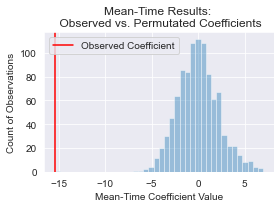

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4,3))
sns.distplot(mean_time, ax= ax, kde=False)
ax.set_title('Mean-Time Results: \n Observed vs. Permutated Coefficients')
ax.set_xlabel('Mean-Time Coefficient Value')
ax.set_ylabel('Count of Observations')
ax.axvline(x=-15.4707, c='r', label='Observed Coefficient')
plt.legend()
plt.tight_layout()
plt.savefig('images/mean_time.png', dpi=300)

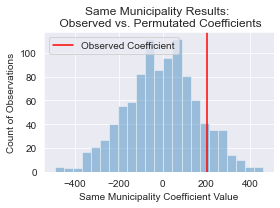

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4,3))
sns.distplot(same_munic, ax= ax, kde=False)
ax.set_title('Same Municipality Results: \n Observed vs. Permutated Coefficients')
ax.set_xlabel('Same Municipality Coefficient Value')
ax.set_ylabel('Count of Observations')
ax.axvline(x=200.06, c='r', label='Observed Coefficient')
plt.legend()
plt.tight_layout()
plt.savefig('images/same_munic_qap.png', dpi=300)

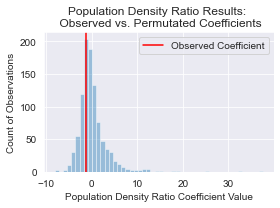

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4,3))
sns.distplot(pop_dens_ratio, ax= ax, kde=False)
ax.set_title('Population Density Ratio Results: \n Observed vs. Permutated Coefficients')
ax.set_xlabel('Population Density Ratio Coefficient Value')
ax.set_ylabel('Count of Observations')
ax.axvline(x=-1.3671, c='r', label='Observed Coefficient')
plt.legend()
plt.tight_layout()
plt.savefig('images/pop_dens.png', dpi=300)

# Section 3: Betweenness Centrality {-}

### Generate Betweenness Centrality Values for: {-}

$$\alpha=0$$
$$\alpha=0.5$$
$$\alpha=1$$
$$\alpha=1.5$$


In [ ]:
for edge in G.edges:
    G.edges[edge]['alpha0'] = 1
    G.edges[edge]['alpha0.5'] = 1 / (G.edges[edge]['count'])**0.5
    G.edges[edge]['alpha1.5'] = 1 / (G.edges[edge]['count'])**1.5
    G.edges[edge]['alpha1'] = 1 / (G.edges[edge]['count'])

In [ ]:
alpha0 = nx.betweenness_centrality(G, weight='alpha0')
alpha0_5 = nx.betweenness_centrality(G, weight='alpha0.5')
alpha1 = nx.betweenness_centrality(G, weight='alpha1')
alpha1_5 = nx.betweenness_centrality(G, weight='alpha1.5')

In [ ]:
alpha0 = pd.Series(alpha0)
alpha0 = pd.DataFrame(alpha0)

alpha0_5 = pd.Series(alpha0_5)
alpha0_5 = pd.DataFrame(alpha0_5)

alpha1 = pd.Series(alpha1)
alpha1 = pd.DataFrame(alpha1)

alpha1_5 = pd.Series(alpha1_5)
alpha1_5 = pd.DataFrame(alpha1_5)

### Plot Distributions {-}

#### $$\alpha=0$$

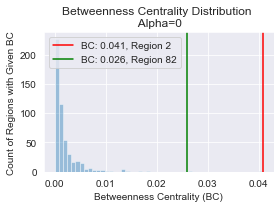

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 3))
sns.distplot(alpha0[0], ax=ax, kde=False)
ax.axvline(x =alpha0[0].max(), label=f'BC: {alpha0[0].max():.3f}, Region 2', c='r')
ax.axvline(x =0.026, label=f'BC: {0.026}, Region 82', c='g')
ax.set_title('Betweenness Centrality Distribution \n Alpha=0')
ax.set_xlabel("Betweenness Centrality (BC)")
ax.set_ylabel("Count of Regions with Given BC")
plt.legend()
plt.tight_layout()
plt.savefig("alpha0_BC.png", dpi=300)

#### $$\alpha=0.5$$

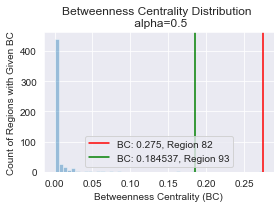

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 3))
sns.distplot(alpha0_5[0], ax=ax, kde=False)
ax.axvline(x =alpha0_5[0].max(), label=f'BC: {alpha0_5[0].max():.3f}, Region 82', c='r')
ax.axvline(x = 0.184537, label=f'BC: {0.184537}, Region 93', c='g')
ax.set_title('Betweenness Centrality Distribution \n alpha=0.5')
ax.set_xlabel("Betweenness Centrality (BC)")
ax.set_ylabel("Count of Regions with Given BC")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("alpha0_5_BC.png", dpi=300)

#### $$\alpha=1$$

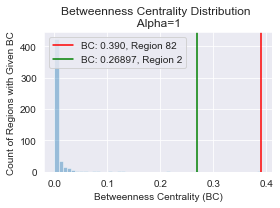

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 3))
sns.distplot(alpha1[0], ax=ax, kde=False)
ax.axvline(x =alpha1[0].max(), label=f'BC: {alpha1[0].max():.3f}, Region 82', c='r')
ax.axvline(x = 0.268970, label=f'BC: {0.268970}, Region 2', c='g')
ax.set_title('Betweenness Centrality Distribution \n Alpha=1')
ax.set_xlabel("Betweenness Centrality (BC)")
ax.set_ylabel("Count of Regions with Given BC")
plt.legend()
plt.tight_layout()
plt.savefig("alpha1_BC.png", dpi=300)

#### $$\alpha=1.5$$

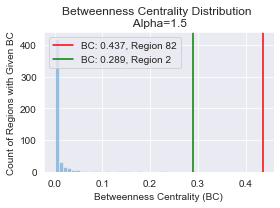

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 3))
sns.distplot(alpha1_5[0], ax=ax, kde=False)
ax.axvline(x =alpha1_5[0].max(), label=f'BC: {alpha1_5[0].max():.3f}, Region 82', c='r')
ax.axvline(x = 0.289, label=f'BC: {0.289}, Region 2', c='g')
ax.set_title('Betweenness Centrality Distribution \n Alpha=1.5')
ax.set_xlabel("Betweenness Centrality (BC)")
ax.set_ylabel("Count of Regions with Given BC")
plt.legend()
plt.tight_layout()
plt.savefig("alpha1.5_BC.png", dpi=300)